# MNIST Classification with a Fully-Connected Net in TensorFlow 

<h2>Imports / magic (%)</h2>

In [20]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

from mnist_loader import load

# compiles operation graphs at intermediate steps (instead of at end)
sess = tf.InteractiveSession()

<h2>Hyper Parameters</h2>

In [21]:
# Hyper params
INPUT_SIZE = 784
HIDDEN_SIZE = 200
OUTPUT_SIZE = 10

LEARNING_RATE = 0.3
EPOCHS = 400
MINIBATCH_SIZE = 5

## Load Data and Input Placeholders
<p>The input matrix has
<ul>
    <li>First dimension = training examples
    <li>Second dimension = features
</ul></p>
<p>ie. an m x n matrix has m training examples each with n features.</p>

Retrieving standard mnist set
Loaded data set


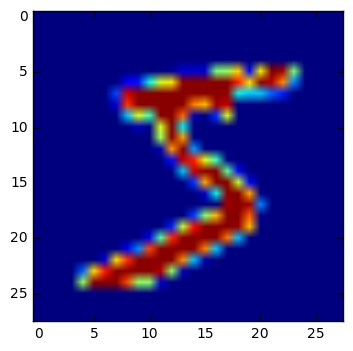

In [22]:
# Load data
path = "Data\mnist.pkl.gz"
train_data, validation_data, test_data = load(path)

# Tuples of (img, label) --> list of imgs, list of labels
train_imgs, train_labels = zip(*train_data)
train_imgs = np.vstack(train_imgs)
# Tuples of (img, label) --> list of imgs, list of labels
vali_imgs, vali_labels = zip(*validation_data)
vali_imgs = np.vstack(vali_imgs)

# Placeholder vars
# float pixel values of images
inputs = tf.placeholder(tf.float32, name="inputs")
# integer target labels of each image
labels = tf.placeholder(tf.int32, name="labels")

# Change index of train_imgs to see other images
plt.imshow(np.reshape(train_imgs[0], (28, 28)))

<h2>Initialize Layers:</h2>
<p>Each weight matrix has:
<ul>
    <li>First dim = size of previous layer
    <li>Second dim = size of current layer
</ul></p>

<p>for multiplication with inputs. The individual weights are randomly initialized with:
<ul>
    <li>Mean = 0
    <li>Standard devation = 1 / sqrt(n), n = size of previous layer
</ul></p>
<p>This initialization prevents saturation in activation function with a narrow distribution and (ideally) leads to faster learning.</p>
<p>The biases are initialized as an all-zero column vector.</p>

In [23]:
with tf.name_scope("hidden"):
    weights = tf.Variable(
        tf.truncated_normal([INPUT_SIZE, HIDDEN_SIZE], 
                             stddev=(1 / (INPUT_SIZE ** 0.5))),
        name="weights")
    biases = tf.Variable(tf.zeros([HIDDEN_SIZE]), name="biases")
    # inputs is placeholder, weights and biases are Variables
    hidden = tf.sigmoid(tf.matmul(inputs, weights) + biases)

with tf.name_scope("output"):
    weights2 = tf.Variable(
        tf.truncated_normal([HIDDEN_SIZE, OUTPUT_SIZE], 
                             stddev=(1 / (HIDDEN_SIZE ** 0.5))),
        name="weights")
    biases2 = tf.Variable(tf.zeros([OUTPUT_SIZE]), name="biases")
    # logits: unscaled outputs of layer (ie no activation)
    # softmax scaling on output is computed along with error later on
    logits = tf.matmul(hidden, weights2) + biases2

## Evaluation / feedforward operations

In [24]:
# Op for a feedforward pass
# Reduce across dimension 1 (col) to get argmax of each row
feedforward = tf.argmax(tf.nn.softmax(logits), 1)

# Op for evaluating accuracy against labels
comparison = tf.equal(tf.cast(feedforward, tf.int32), labels)
evaluation = tf.reduce_mean(tf.cast(comparison, tf.float32))

## Initialize Training Operations

In [25]:
# Softmax activation with cross entropy cost
xent = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels, name="xent")
cost = tf.reduce_mean(xent, name="cost")
# Counter incremented each step of gradient descent (why?)
global_step = tf.Variable(0, name="global_step", trainable=False)
# Descent algorithm
sgd = tf.train.GradientDescentOptimizer(LEARNING_RATE)

train = sgd.minimize(cost, global_step=global_step)

In [26]:
# All variables should have been constructed by now - now initialize
sess.run(tf.global_variables_initializer())
# Operation for saving params
saver = tf.train.Saver()

## Training

In [27]:
t0 = time.time()
costs = []
vali_accuracy = []
for i in range(EPOCHS):
    # Returns activations from "train", "cost", and "eval"
    _, cost_val = sess.run([train, cost], feed_dict={inputs: train_imgs, labels: train_labels})
    eval_acc = sess.run([evaluation], feed_dict={inputs: vali_imgs, labels: vali_labels})
    costs.append(cost_val)
    vali_accuracy.append(eval_acc)
    
    if i > 0 and i % (EPOCHS // 10) == 0:
        dt = time.time() - t0
        print("Epoch: {}, time elapsed: {}, time to go: {}".format(
                i, dt, dt / i * (EPOCHS - i)))

##saver.save(sess, "checkpoint", global_step=i)

Epoch: 40, time elapsed: 31.36579394340515, time to go: 282.29214549064636
Epoch: 80, time elapsed: 64.86871027946472, time to go: 259.4748411178589
Epoch: 120, time elapsed: 98.64064192771912, time to go: 230.1614978313446
Epoch: 160, time elapsed: 131.9765486717224, time to go: 197.96482300758362
Epoch: 200, time elapsed: 166.50052332878113, time to go: 166.50052332878113
Epoch: 240, time elapsed: 201.20350813865662, time to go: 134.13567209243774
Epoch: 280, time elapsed: 234.53441452980042, time to go: 100.51474908420018
Epoch: 320, time elapsed: 268.97238421440125, time to go: 67.24309605360031
Epoch: 360, time elapsed: 303.2563452720642, time to go: 33.695149474673805


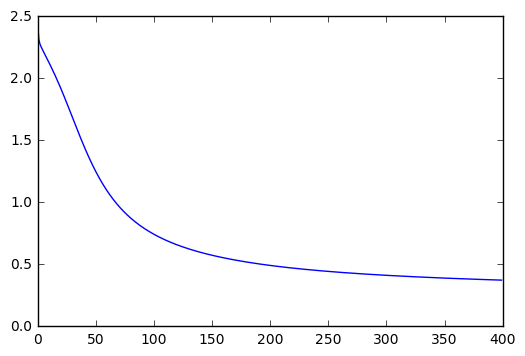

In [28]:
plt.plot(range(EPOCHS), costs, label="costs")

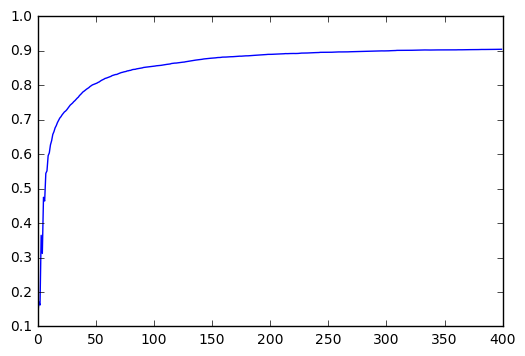

In [29]:
plt.plot(range(EPOCHS), vali_accuracy, label="validation accuracy")